# 4. Optimus, Learning and Resource models, Performance-cost tradeoffs

## 4.1. 
Gathered data with the following students:

1. Tamanna Ananna, ta2642
2. David Heagy, dh2868
3. Viren Bajaj, vb2519
4. Ravish Rawal, rr2914

In [77]:
#!unzip -o resnet-history.zip

Archive:  resnet-history.zip
  inflating: resnet-history/resnet44-k80.csv  
  inflating: __MACOSX/resnet-history/._resnet44-k80.csv  
  inflating: resnet-history/resnet20-v100.csv  
  inflating: __MACOSX/resnet-history/._resnet20-v100.csv  
  inflating: resnet-history/resnet56-v100.csv  
  inflating: __MACOSX/resnet-history/._resnet56-v100.csv  
  inflating: resnet-history/resnet50-p100.csv  
  inflating: resnet-history/resnet18-p100.csv  
  inflating: __MACOSX/resnet-history/._resnet18-p100.csv  
  inflating: resnet-history/.DS_Store  
  inflating: __MACOSX/resnet-history/._.DS_Store  
  inflating: resnet-history/resnet18-k80.csv  
  inflating: __MACOSX/resnet-history/._resnet18-k80.csv  
  inflating: resnet-history/resnet56-p100.csv  
  inflating: __MACOSX/resnet-history/._resnet56-p100.csv  
  inflating: resnet-history/resnet20-p100.csv  
  inflating: __MACOSX/resnet-history/._resnet20-p100.csv  
  inflating: resnet-history/resnet56-k80.csv  
  inflating: __MACOSX/resnet-history/._r

In [78]:
#!ls resnet-history

resnet18-k80.csv   resnet32-k80.csv   resnet44-v100.csv  resnet56-p100.csv
resnet18-p100.csv  resnet32-p100.csv  resnet50-k80.csv	 resnet56-v100.csv
resnet18-v100.csv  resnet32-v100.csv  resnet50-p100.csv  results20-k80.csv
resnet20-p100.csv  resnet44-k80.csv   resnet50-v100.csv
resnet20-v100.csv  resnet44-p100.csv  resnet56-k80.csv


In [96]:
from os import listdir
from os.path import splitext, join

from scipy.optimize import curve_fit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data_dir = 'resnet-history'
files = listdir(data_dir)


history = {}

for file in files:
    file_info = splitext(file)
    if file_info[-1] == '.csv':
        results = pd.read_csv(join(data_dir, file))
        results['model'] = file_info[0]
        history[file_info[0]] = results
        
history.keys()

dict_keys(['resnet32-v100', 'resnet56-k80', 'resnet32-p100', 'resnet50-p100', 'resnet18-p100', 'resnet50-k80', 'resnet18-v100', 'resnet50-v100', 'resnet20-k80', 'resnet44-k80', 'resnet20-p100', 'resnet56-p100', 'resnet44-v100', 'resnet44-p100', 'resnet32-k80', 'resnet20-v100', 'resnet56-v100', 'resnet18-k80'])

In [3]:
history['resnet18-k80'].head()

,epoch,steps,training step,training data,training loss,training prec1,training prec5,training error1,training error5,validation step,validation data,validation loss,validation prec1,validation prec5,validation error1,validation error5,model
0,1,390,0.062469,0.005346,1.741367,33.671875,85.889423,66.328125,14.110577,0.038952,0.020096,1.608177,43.71,89.86,56.29,10.14,resnet18-k80
1,2,780,0.062429,0.005023,1.240431,54.196715,94.917869,45.803285,5.082131,0.038416,0.019594,1.424388,53.23,94.83,46.77,5.17,resnet18-k80
2,3,1170,0.063096,0.004628,1.014315,63.601763,96.786859,36.398237,3.213141,0.038704,0.020167,1.261538,57.89,96.00,42.11,4.00,resnet18-k80
3,4,1560,0.062571,0.005146,0.876357,68.918269,97.578125,31.081731,2.421875,0.038164,0.019761,1.382180,59.48,97.45,40.52,2.55,resnet18-k80
4,5,1950,0.062839,0.005385,0.776889,72.618189,98.191106,27.381811,1.808894,0.037872,0.019627,0.830184,72.44,97.65,27.56,2.35,resnet18-k80


In [4]:
# separate out data for resnet50

test_data_keys = {'resnet50-k80', 'resnet50-p100', 'resnet50-v100'}
test_history = {}

for model_key in test_data_keys:
    test_history[model_key] = history.pop(model_key)
    
test_history.keys()

dict_keys(['resnet50-k80', 'resnet50-v100', 'resnet50-p100'])

In [5]:
history.keys()

dict_keys(['resnet32-v100', 'resnet56-k80', 'resnet32-p100', 'resnet18-p100', 'resnet18-v100', 'resnet20-k80', 'resnet44-k80', 'resnet20-p100', 'resnet56-p100', 'resnet44-v100', 'resnet44-p100', 'resnet32-k80', 'resnet20-v100', 'resnet56-v100', 'resnet18-k80'])

In [80]:
# train Optimus model

# I modify the reciprocal curve we are fitting to make it more flexible
def reciprocal(k, b0, b1, b2):
    #return 1.0 / (b0 * k + b1) + b2
    return b0 / (k + b1) + b2

optimus = {}

for model_name, data in sorted(history.items()):
    b, _ = curve_fit(
        f = reciprocal,
        xdata = data['epoch'],
        ydata = data['training loss'],
        method = 'dogbox'
    )
        
    optimus[model_name] = b

optimus

{'resnet18-k80': array([10.07896606,  6.21908239,  0.01161789]),
 'resnet18-p100': array([10.24282023,  6.18077182,  0.01104777]),
 'resnet18-v100': array([10.25607717,  6.3102748 ,  0.01193309]),
 'resnet20-k80': array([ 9.45533639,  5.58775432, -0.01380617]),
 'resnet20-p100': array([ 9.39321446,  5.50874966, -0.01348753]),
 'resnet20-v100': array([ 9.56309898,  5.58462084, -0.01426609]),
 'resnet32-k80': array([ 8.34921795,  4.89548639, -0.02133052]),
 'resnet32-p100': array([ 8.03170504,  4.6121392 , -0.02008437]),
 'resnet32-v100': array([ 8.39564039,  4.86026457, -0.02152606]),
 'resnet44-k80': array([ 7.84110106,  4.46291429, -0.02244884]),
 'resnet44-p100': array([ 7.92993961,  4.50858201, -0.02330397]),
 'resnet44-v100': array([ 7.59803734,  4.20706835, -0.02187049]),
 'resnet56-k80': array([ 7.60825634,  4.23644261, -0.02339091]),
 'resnet56-p100': array([ 7.5833425 ,  4.19450118, -0.02344406]),
 'resnet56-v100': array([ 7.27731839,  3.95952569, -0.02196401])}

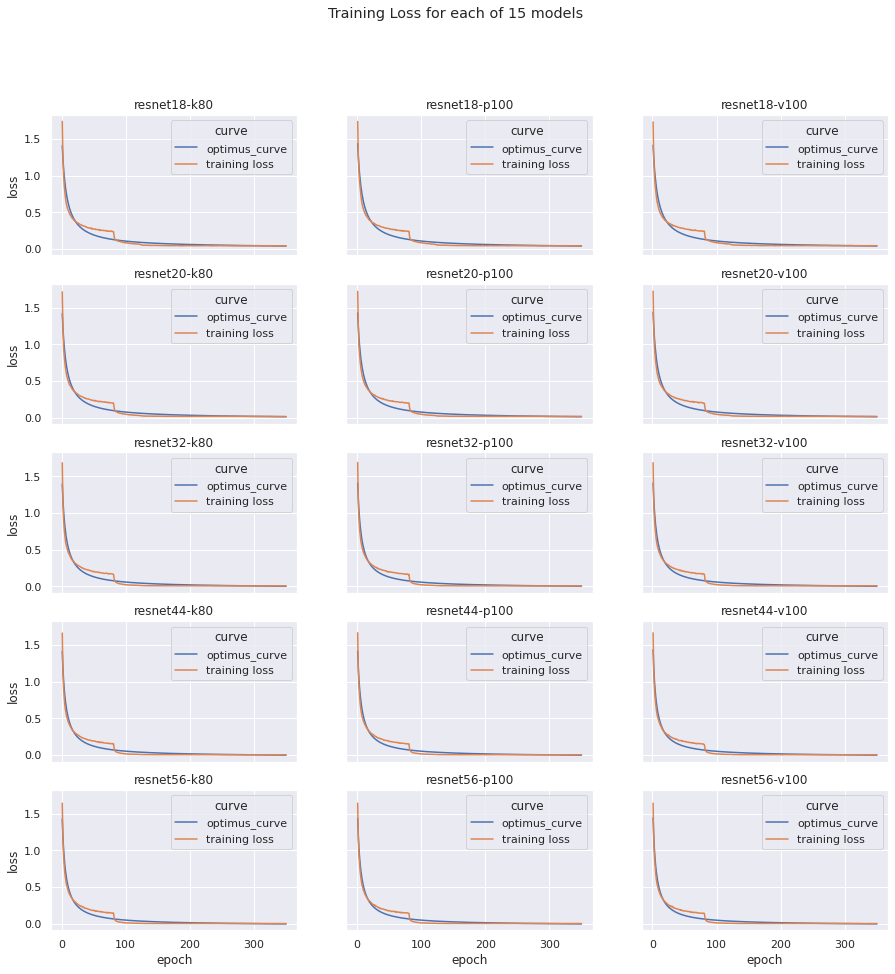

In [81]:
fig, axes = plt.subplots(5, 3, figsize = (15, 15), sharex = True, sharey = True)


for (model, results), (modelo, b), ax in zip(sorted(history.items()), sorted(optimus.items()), axes.reshape(-1)):
    assert model == modelo
    
    results = results.assign(optimus_curve = lambda x: reciprocal(x.epoch, b[0], b[1], b[2]))
    results = pd.melt(
        results, 
        id_vars = ['epoch'], 
        value_vars = ['optimus_curve', 'training loss'],
        var_name = 'curve',
        value_name = 'loss')
    
    sns.lineplot(ax = ax, data = results, x = 'epoch', y = 'loss', hue = 'curve')
    ax.title.set_text(model)
fig.suptitle('Training Loss for each of 15 models')
plt.ylim
plt.show()

## 4.2.

In [83]:
optimus_df = pd.DataFrame.from_dict(
    optimus, orient = 'index', columns = ['b0', 'b1', 'b2'])

optimus_df.index.name = 'model'
optimus_df.reset_index(inplace = True)

optimus_df['gpu'] = optimus_df['model'].str.partition('-').iloc[:, -1]
optimus_df['layers'] = optimus_df['model'].str.partition('-').iloc[:, 0].str[-2:].astype(int)

optimus_df

,model,b0,b1,b2,gpu,layers
0,resnet18-k80,10.078966,6.219082,0.011618,k80,18
1,resnet18-p100,10.242820,6.180772,0.011048,p100,18
2,resnet18-v100,10.256077,6.310275,0.011933,v100,18
3,resnet20-k80,9.455336,5.587754,-0.013806,k80,20
4,resnet20-p100,9.393214,5.508750,-0.013488,p100,20
5,resnet20-v100,9.563099,5.584621,-0.014266,v100,20
6,resnet32-k80,8.349218,4.895486,-0.021331,k80,32
7,resnet32-p100,8.031705,4.612139,-0.020084,p100,32
8,resnet32-v100,8.395640,4.860265,-0.021526,v100,32
9,resnet44-k80,7.841101,4.462914,-0.022449,k80,44


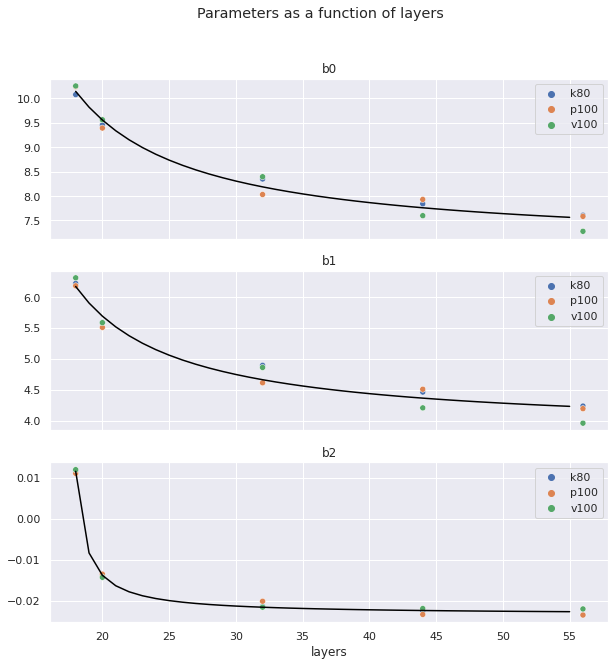

[array([28.56996413, -9.08028624,  6.94167626]), array([ 18.27478987, -10.20970375,   3.82366728]), array([  0.02632952, -17.24458685,  -0.02332653])]


In [99]:
fig, axes = plt.subplots(3, 1, figsize = (10, 10), sharex = True)

params = ['b0', 'b1', 'b2']

model = []

xlayers = np.arange(min(optimus_df['layers']), max(optimus_df['layers']))


for ax, param in zip(axes, params):

    m, _ = curve_fit(
        f = reciprocal,
        xdata = optimus_df['layers'],
        ydata = optimus_df[param],
        method = 'dogbox'
    )
    
    model.append(m)
    
    sns.scatterplot(ax = ax, data = optimus_df, x = 'layers', y = param, hue = 'gpu')
    sns.lineplot(ax = ax, x = xlayers, y = reciprocal(xlayers, m[0], m[1], m[2]), color = 'black')
    ax.title.set_text(param)
    ax.set_ylabel('')

plt.suptitle('Parameters as a function of layers')
plt.show()

print(model)

In [105]:
model_df = pd.DataFrame(np.stack(model), columns = ['m0', 'm1', 'm2'], index = ['b0', 'b1', 'b2'])

model_df.index.name = 'b'

model_df

,m0,m1,m2
b,,,
b0,28.569964,-9.080286,6.941676
b1,18.274790,-10.209704,3.823667
b2,0.026330,-17.244587,-0.023327


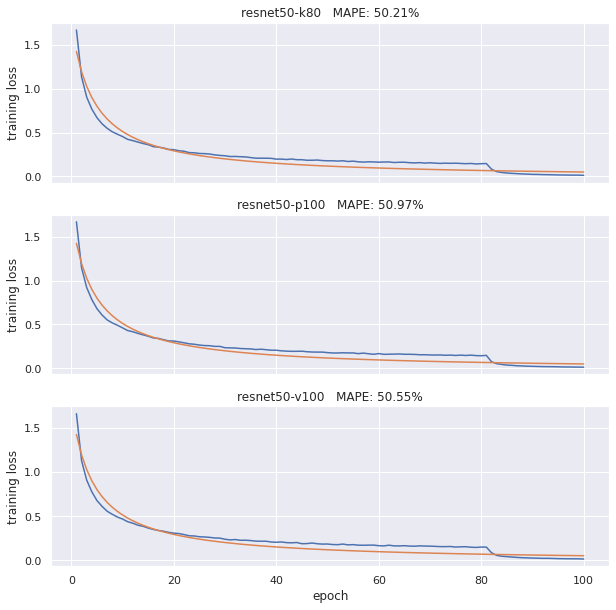

In [144]:
qlayer = 50

b0_pred = reciprocal(qlayer, model_df.loc['b0', 'm0'], model_df.loc['b0', 'm1'], model_df.loc['b0', 'm2'])
b1_pred = reciprocal(qlayer, model_df.loc['b1', 'm0'], model_df.loc['b1', 'm1'], model_df.loc['b1', 'm2'])
b2_pred = reciprocal(qlayer, model_df.loc['b2', 'm0'], model_df.loc['b2', 'm1'], model_df.loc['b2', 'm2'])


epochs = 100
train_loss_pred = reciprocal(np.arange(1, epochs + 1), b0_pred, b1_pred, b2_pred)

# plot
fig, axes = plt.subplots(3, 1, figsize = (10, 10), sharex = True)

for (model, results), ax in zip(sorted(test_history.items()), axes):
    
    pct_error = sum(
        abs(results['training loss'][:epochs] - train_loss_pred) / results['training loss'][:epochs]
    ) / epochs * 100
    
    sns.lineplot(ax = ax, data = results[:epochs], x = 'epoch', y = 'training loss')
    sns.lineplot(ax = ax, x = np.arange(1, epochs + 1), y = train_loss_pred)
    ax.title.set_text('%s   MAPE: %.2f%%' % (model, pct_error))

Notice that the Mean Absolute Percentage Error (MAPE) is not much different across GPU types. Therefore we conclude that convergence is not a function of GPU hardware.